# TP 3.3 — Modèles d'état (SSM) : de la théorie à Mamba

Ce carnet reprend pas-à-pas le TP consacré aux *State Space Models* (SSM). Nous allons
passer de la formulation continue aux implémentations PyTorch, jusqu'à une variante sélective
inspirée de Mamba. Chaque section s'accompagne de rappels mathématiques, de commentaires
pédagogiques et d'illustrations pour faciliter l'appropriation des concepts.


## Origines et contexte
Les *State Space Models* (SSM) constituent un langage commun entre le traitement du signal, la théorie du contrôle et l'apprentissage automatique. Historiquement, ils décrivent l'évolution d'un système linéaire via un état caché : leur puissance vient de la possibilité de combiner dynamiques internes et observations partielles (filtrage de Kalman, identification de systèmes, etc.).

Les travaux récents en deep learning (S4, S4D, HiPPO) ont remis les SSM sur le devant de la scène en montrant que, bien paramétrés, ils rivalisent avec des architectures séquentielles classiques pour traiter des dépendances longues. Deux idées clés :
- **Paramétrisation stable et diagonalisable** : la dynamique continue est choisie telle que les exponentielles restent stables et faciles à discrétiser exactement.
- **Calcul parallèle via convolution** : le lien SSM ↔ filtre causal permet de tirer parti de convolutions rapides sur GPU.

Les modèles **Mamba** généralisent encore cette vision en rendant le pas de discrétisation et les portes dépendants de l'entrée. On obtient ainsi des filtres *sélectifs* capables d'ajuster leur temps caractéristique, ce qui améliore l'alignement avec des signaux non stationnaires ou des long-range tasks.

Ce TP propose une plongée progressive dans ces concepts : de la formule continue à l'entraînement d'un SSM sélectif sur deux tâches représentatives.


## Objectifs pédagogiques
- Relier la dynamique diagonalisable d'un SSM continu à sa version discrète utilisée en apprentissage profond.
- Construire le noyau de convolution causal équivalent et vérifier numériquement l'équivalence `scan` vs `conv`.
- Manipuler des jeux de données synthétiques pour le filtrage et l'"adding task".
- Entraîner des modèles SSM diagonaux et sélectifs, analyser les réponses temporelles et fréquentielles.
- Comprendre comment la sélectivité temporelle rapproche les SSM des architectures Mamba.


## Guide de lecture et progression pédagogique
Chaque section est construite pour amener progressivement les notions essentielles :
1. **Préparation** — installation du contexte expérimental (imports, graine, répertoire de figures) : s'assurer que les runs sont reproductibles.
2. **Rappels théoriques** — partir de la forme continue des SSM, montrer la discrétisation exacte et présenter l'interprétation en convolution : cette partie articule les équations fondamentales et les prépare à l'implémentation.
3. **Jeux de données** — deux scénarios complémentaires : un filtre passe-bas causal (lecture traitement du signal) et l'adding task (mémoire sélective). On y explicite le rôle des SSM.
4. **Implémentations PyTorch** — traduction directe des équations en modules `DiagSSMLayer` et `SelectiveSSMLayer`. On insiste sur la stabilité, la discretisation, le lien conv/scan.
5. **Entraînement** — mise en œuvre des fonctions d'apprentissage, configuration commune via `TrainConfig`, et collecte des sorties nécessaires aux analyses.
6. **Visualisations** — lecture dirigée des courbes. On cherche à comprendre ce que racontent les noyaux temporels, les réponses fréquentielles et les pas adaptatifs.
7. **Ouvertures** — pistes pour prolonger l'exploration : variations d'hyperparamètres, modes conv/scan, rapprochement accru avec Mamba.

> L'idée directrice : *partir de la théorie contrôle/filtrage → coder les briques → entraîner → analyser*. À chaque étape, retenez comment les choix mathématiques se répercutent sur les courbes observées.


## 0. Préparation de l'environnement
Nous chargeons les bibliothèques nécessaires, fixons les graines pseudo-aléatoires et créons le dossier qui accueillera les figures. Les graphiques sont affichés directement dans le notebook pour permettre un aller-retour rapide entre code et observations.


In [1]:
# %% Imports et configuration globale
%matplotlib inline
import os
import math
import time
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")

# Répertoire pour sauvegarder d'éventuelles figures
SAVE_DIR = Path("figs_tp_ssm")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Utilisation de {DEVICE.upper()} pour les tenseurs.")


def set_seed(seed: int = 123):
    """Fixe les graines NumPy et PyTorch pour des résultats reproductibles."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


SEED = 123
set_seed(SEED)


Utilisation de CUDA pour les tenseurs.


## 1. Rappels sur les State Space Models

Un SSM linéaire continu sur un état $x(t) \in \mathbb{R}^N$ et une entrée $u(t) \in \mathbb{R}^{d_{\text{in}}}$ s'écrit

$$
\frac{d x(t)}{d t} = A x(t) + B u(t), \qquad y(t) = C x(t) + D u(t),
$$

avec $A \in \mathbb{R}^{N \times N}$ la dynamique, $B \in \mathbb{R}^{N \times d_{\text{in}}}$ l'injection d'entrée, $C \in \mathbb{R}^{d_{\text{out}} \times N}$ la projection de l'état et $D \in \mathbb{R}^{d_{\text{out}} \times d_{\text{in}}}$ le terme direct (skip connection).

Dans ce TP, nous considérons le cas **diagonal stable** : $A = \mathrm{diag}(a)$ avec $a_i < 0$. Cette hypothèse
permet des discrétisations exactes simples et une implémentation efficace.


### 1.1 Discrétisation exacte (C→D)
Pour un pas d'échantillonnage $\Delta t > 0$, la solution exacte de l'équation différentielle linéaire conduit au système discret

$$
\begin{aligned}
\mathbf{x}_{t+1} &= \underbrace{\exp(\Delta t \cdot A)}_{\bar{A}} \mathbf{x}_t + \underbrace{A^{-1}(\bar{A} - I)}_{\text{intégrale exacte}} B \mathbf{u}_t, \\
\mathbf{y}_t &= C \mathbf{x}_t + D \mathbf{u}_t.
\end{aligned}
$$

Dans le cas diagonal, chaque entrée se traite indépendamment :

$$
\bar{A}_i = e^{\Delta t a_i}, \qquad \bar{B}_{i,:} = \frac{e^{\Delta t a_i} - 1}{a_i} B_{i,:},
$$
avec la convention $\bar{B}_{i,:} = \Delta t \cdot B_{i,:}$ lorsque $a_i \approx 0$ pour éviter les divisions numériques instables.


In [2]:
def c2d_diagonal(a_diag: torch.Tensor, B: torch.Tensor, dt: float):
    """Discrétisation exacte d'un SSM diagonal stable."""
    a = a_diag
    dt = torch.as_tensor(dt, dtype=a.dtype, device=a.device)
    eA = torch.exp(dt * a)
    eps = torch.tensor(1e-6, dtype=a.dtype, device=a.device)
    coeff = torch.where(torch.abs(a) > eps, (eA - 1.0) / a, dt.expand_as(a))
    B_bar = coeff[:, None] * B
    A_bar = eA
    return A_bar, B_bar


### Illustration : Euler vs discrétisation exacte
Nous comparons la discrétisation exacte à l'approximation d'Euler explicite ($\bar{A} \approx I + \Delta t A$). Les écarts deviennent marqués pour des pas de temps plus grands ou des dynamiques raides.


a (continu): [-0.2935902 -1.5722826 -1.8936433]
A_bar exact: [0.9429726  0.7301856  0.68473136]
A_bar Euler: [0.941282  0.6855435 0.6212714]


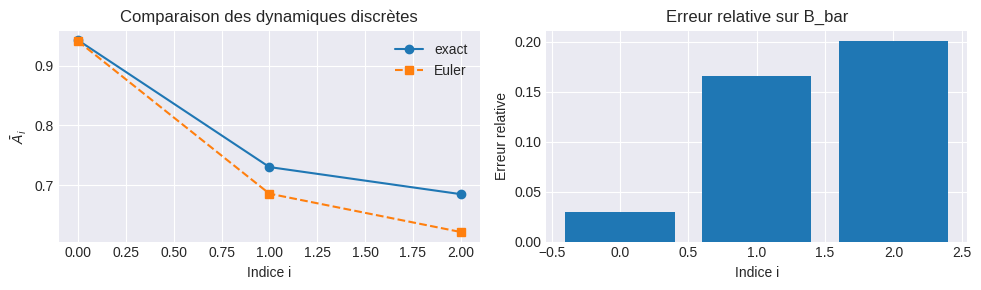

In [3]:
# Exemple numérique
set_seed(7)
N = 3
a = -torch.abs(torch.randn(N)) * 2.0
B = torch.randn(N, 1)
dt = 0.2

A_bar_exact, B_bar_exact = c2d_diagonal(a, B, dt)
A_bar_euler = 1.0 + dt * a
B_bar_euler = dt * B

print("a (continu):", a.numpy())
print("A_bar exact:", A_bar_exact.numpy())
print("A_bar Euler:", A_bar_euler.numpy())

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].set_title("Comparaison des dynamiques discrètes")
axes[0].plot(A_bar_exact.cpu().numpy(), "o-", label="exact")
axes[0].plot(A_bar_euler.cpu().numpy(), "s--", label="Euler")
axes[0].set_xlabel("Indice i")
axes[0].set_ylabel(r"$\bar{A}_i$")
axes[0].legend()

axes[1].set_title("Erreur relative sur B_bar")
rel_err = ((B_bar_exact - B_bar_euler).abs() / (B_bar_exact.abs() + 1e-9)).cpu().numpy()
axes[1].bar(range(N), rel_err.squeeze())
axes[1].set_xlabel("Indice i")
axes[1].set_ylabel("Erreur relative")
plt.tight_layout()
plt.show()


## 2. Du système discret à la convolution causale
En itérant le système discret, on obtient un noyau causal $k$ tel que

$$\mathbf{y} = k *_{\text{causal}} \mathbf{u}, \qquad k_t = C \bar{A}^t \bar{B}.$$

Cette représentation parallèle (via une convolution 1D) est particulièrement adaptée aux GPU.


In [4]:
def ssm_kernel_from_diagonal(C: torch.Tensor, A_bar: torch.Tensor, B_bar: torch.Tensor, L: int):
    """Construit le noyau causal k[0..L-1] pour un SSM diagonal discret."""
    d_out, N = C.shape
    assert A_bar.shape == (N,)
    assert B_bar.shape[0] == N
    k = []
    H = B_bar.clone()
    for _ in range(L):
        k.append(torch.matmul(C, H))
        H = A_bar[:, None] * H
    return torch.stack(k, dim=-1)


def causal_conv1d_from_kernel(u: torch.Tensor, k: torch.Tensor) -> torch.Tensor:
    """Applique la convolution causale définie par k sur une séquence u."""
    Bsz, L, d_in = u.shape
    d_out, d_in_k, Lk = k.shape
    assert d_in == d_in_k
    u_t = u.permute(0, 2, 1)
    k_flip = torch.flip(k, dims=[-1])
    y = F.conv1d(u_t, k_flip, padding=Lk - 1)
    y = y[:, :, :L]
    return y.permute(0, 2, 1)


### Illustration : réponse impulsionnelle et spectre
Générons un SSM diagonal aléatoire, calculons son noyau causal et visualisons :
- la réponse impulsionnelle $k[t]$ ;
- la réponse fréquentielle $|K(\omega)|$ (FFT) exprimée en dB.


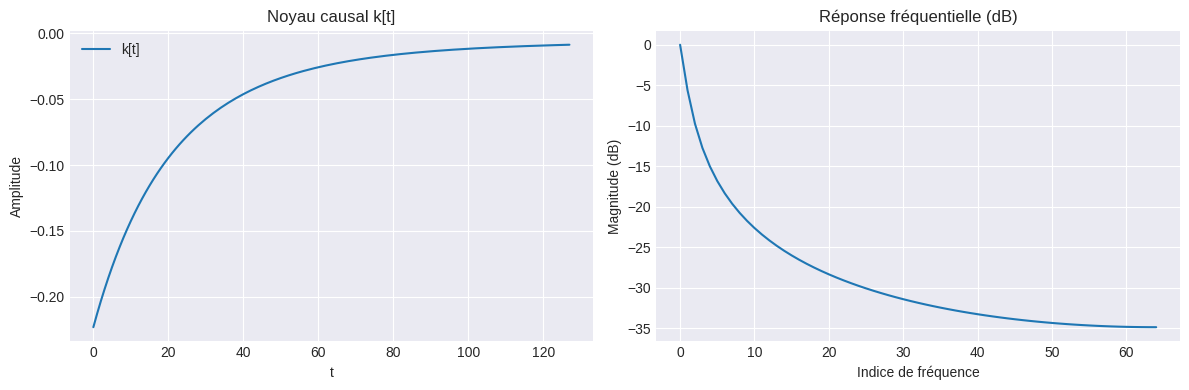

In [5]:
set_seed(21)
N = 16
C = torch.randn(1, N)
a = -torch.linspace(0.1, 2.0, steps=N)
B = torch.randn(N, 1)
dt = 0.05
A_bar, B_bar = c2d_diagonal(a, B, dt)
L_kernel = 128
kernel = ssm_kernel_from_diagonal(C, A_bar, B_bar, L_kernel)

impulse = torch.zeros(1, L_kernel, 1)
impulse[:, 0, 0] = 1.0
response = causal_conv1d_from_kernel(impulse, kernel)[0, :, 0].cpu().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Noyau causal k[t]")
plt.plot(response, label="k[t]")
plt.xlabel("t")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Réponse fréquentielle (dB)")
fft_vals = np.fft.rfft(response)
mag = np.abs(fft_vals)
mag_db = 20 * np.log10(mag / (mag.max() + 1e-12))
plt.plot(mag_db)
plt.xlabel("Indice de fréquence")
plt.ylabel("Magnitude (dB)")
plt.tight_layout()
plt.show()


## 3. Jeux de données synthétiques
Nous allons manipuler deux problèmes classiques pour les SSM :

1. **Filtrage 1D** : séparer un signal basse fréquence d'un mélange bruité.
2. **Adding task** : sommer deux valeurs indiquées par un masque binaire sur une longue séquence.

Ces jeux de données permettent d'explorer la capacité des SSM à modéliser des dépendances temporelles longues.


### Cadre de la mise en pratique
Nous utilisons les SSM pour deux tâches complémentaires :
- **Filtrage passe-bas causal** : apprendre à isoler la composante basse fréquence d'un signal bruité en temps réel. Le SSM agit comme un filtre linéaire, et nous cherchons à observer comment son noyau et sa réponse fréquentielle se comportent.
- **Adding task sélective** : mémoriser deux positions importantes dans une séquence longue pour produire un scalaire. Ici, la dynamique sélective illustre la capacité du SSM à moduler son pas de temps localement.

Ces tâches remplissent deux objectifs pédagogiques :
1. *Perspective traitement du signal* — comprendre comment un SSM stable se comporte comme un filtre causal (réponse impulsionnelle, spectre, comparaison conv/scan).
2. *Perspective mémoire longue portée* — montrer qu'en adaptant ses pas $\Delta_t$, un SSM peut coder des informations ponctuelles distantes et les restituer au bon moment.

> **Pourquoi l'adding task produit-elle un scalaire ?**  
> La cible est la somme des deux valeurs repérées par le masque, lue au dernier pas de temps. Cette formulation impose au modèle de conserver l'information pertinente sur toute la séquence. Les visualisations se concentrent donc sur :
> - l'entrée (valeurs + masque) pour identifier les positions critiques ;
> - l'évolution des $\Delta_t$ et éventuellement de la porte de sortie, qui montrent comment la couche sélective ajuste sa dynamique (analogue à un filtre temporel à pas variable) ;
> - la convergence MSE/MAE qui atteste de la capacité du modèle à retrouver la somme exacte.

Gardez à l'esprit l'objectif de traitement du signal : un bon modèle doit laisser passer les basses fréquences désirées tout en atténuant les hautes fréquences et le bruit, tout en restant causal (sortie dépend uniquement du passé). Parallèlement, la tâche de somme met en évidence la facette « mémoire ciblée » des architectures de type Mamba.



### Pourquoi ces tâches ?
- **Filtrage 1D** : transpose un problème classique de traitement du signal — extraire une composante basse fréquence — dans un cadre différentiable. Il met l'accent sur l'analyse du noyau causal appris et de sa réponse fréquentielle.
- **Adding task** : benchmark historique de mémoire longue portée (Long Range Arena). La sortie est un unique scalaire, calculé au dernier pas, ce qui oblige le modèle à retenir deux événements rarissimes et à combiner leurs amplitudes. C'est un cas d'usage typique pour tester les capacités de sélection temporelle des SSM modernes (Mamba).

Les deux tâches partagent le besoin de causalité mais explorent des comportements différents : filtrage stationnaire vs mémorisation ciblée. Les visualisations correspondantes vous guideront vers les indices pertinents : formes du noyau, spectres, courbes d'erreur, pas adaptatifs $\Delta_t$.



In [6]:
class Filtering1DDataset(Dataset):
    """Signal de référence basse fréquence + composantes hautes + bruit."""
    def __init__(self, n_samples=800, seq_len=256, n_low=2, n_high=2, noise_std=0.2, seed=0):
        super().__init__()
        rng = np.random.RandomState(seed)
        t = np.arange(seq_len)[None, :]
        xs, ys = [], []
        for _ in range(n_samples):
            low_freqs = rng.uniform(0.5, 2.0, size=(n_low, 1))
            low_phs = rng.uniform(0, 2 * np.pi, size=(n_low, 1))
            low = np.sin(2 * np.pi * low_freqs * t / seq_len + low_phs).sum(axis=0)

            high_freqs = rng.uniform(6.0, 20.0, size=(n_high, 1))
            high_phs = rng.uniform(0, 2 * np.pi, size=(n_high, 1))
            high = 0.5 * np.sin(2 * np.pi * high_freqs * t / seq_len + high_phs).sum(axis=0)

            noise = noise_std * rng.randn(1, seq_len)
            u = (low + high + noise).astype(np.float32)
            y = low.astype(np.float32)[:, None]
            xs.append(u.T)
            ys.append(y)
        self.x = np.stack(xs, axis=0)
        self.y = np.stack(ys, axis=0)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]), torch.from_numpy(self.y[idx])


class AddingTaskDataset(Dataset):
    """Deux positions aléatoires marquées dont nous devons sommer les valeurs."""
    def __init__(self, n_samples=800, seq_len=256, seed=0):
        super().__init__()
        rng = np.random.RandomState(seed)
        xs, ys = [], []
        for _ in range(n_samples):
            a = rng.rand(seq_len, 1).astype(np.float32)
            m = np.zeros((seq_len, 1), dtype=np.float32)
            idxs = rng.choice(seq_len, size=2, replace=False)
            m[idxs, 0] = 1.0
            y = np.array([a[idxs, 0].sum()], dtype=np.float32)
            xs.append(np.concatenate([a, m], axis=1))
            ys.append(y)
        self.x = np.stack(xs, axis=0)
        self.y = np.stack(ys, axis=0)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]), torch.from_numpy(self.y[idx])


### Visualisation des données
Les figures suivantes permettent de comprendre immédiatement la structure de chaque tâche.


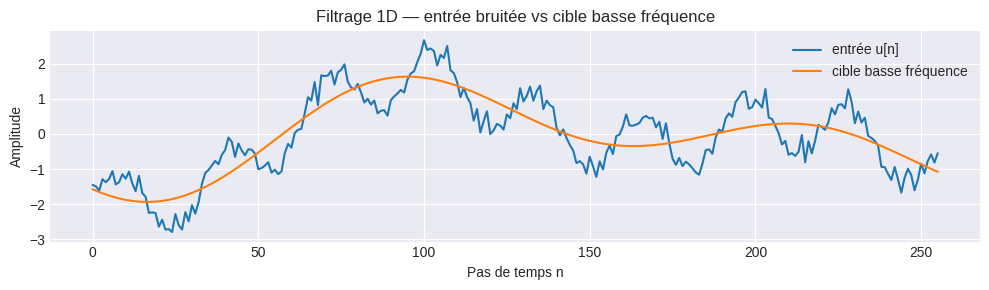

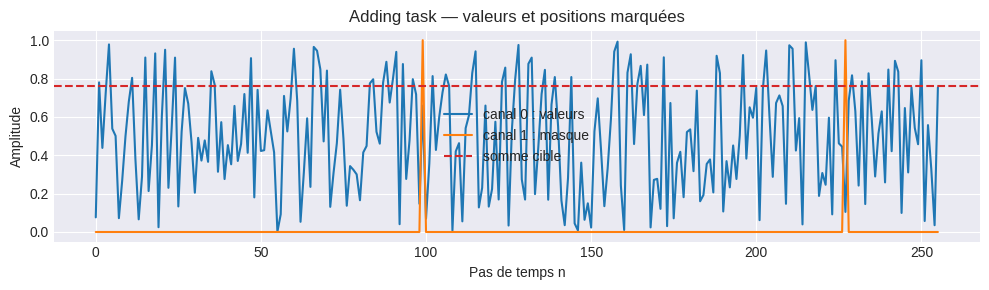

In [7]:
# échantillon filtrage
filter_dataset = Filtering1DDataset(n_samples=1, seq_len=256, seed=42)
u_sample, y_sample = filter_dataset[0]
plt.figure(figsize=(10, 3))
plt.title("Filtrage 1D — entrée bruitée vs cible basse fréquence")
plt.plot(u_sample.numpy(), label="entrée u[n]")
plt.plot(y_sample.numpy(), label="cible basse fréquence")
plt.xlabel("Pas de temps n")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# échantillon adding task
add_dataset = AddingTaskDataset(n_samples=1, seq_len=256, seed=7)
u_add, y_add = add_dataset[0]
plt.figure(figsize=(10, 3))
plt.title("Adding task — valeurs et positions marquées")
plt.plot(u_add[:, 0].numpy(), label="canal 0 : valeurs")
plt.plot(u_add[:, 1].numpy(), label="canal 1 : masque")
plt.axhline(y_add.item(), color="tab:red", linestyle="--", label="somme cible")
plt.xlabel("Pas de temps n")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Implémentation de couches SSM en PyTorch
Nous encapsulons la logique de discrétisation et de convolution dans des modules PyTorch modulaires.

- `DiagSSMLayer` : couche SSM diagonale stable avec mode convolutionnel et mode scan.
- `SelectiveSSMLayer` : version sélective où $\Delta t$ et une porte de sortie dépendent de l'entrée (idée clé de Mamba).


In [8]:
def _softplus_stable(x):
    return F.softplus(x)


class DiagSSMLayer(nn.Module):
    """Implémentation d'un SSM diagonal stable (S4D)."""

    def __init__(self, d_in: int, d_out: int, N: int = 64, dt_init: float = 0.1, use_D: bool = True):
        super().__init__()
        self.N = N
        self.d_in = d_in
        self.d_out = d_out
        self.a_raw = nn.Parameter(torch.randn(N) * 0.01)
        self.B = nn.Parameter(torch.randn(N, d_in) * 0.1)
        self.C = nn.Parameter(torch.randn(d_out, N) * 0.1)
        self.use_D = use_D
        if use_D:
            self.D = nn.Parameter(torch.zeros(d_out, d_in))
        else:
            self.register_parameter("D", None)
        self.log_dt = nn.Parameter(torch.log(torch.tensor(dt_init)))

    def _a(self):
        return -_softplus_stable(self.a_raw)

    def _dt(self):
        return _softplus_stable(self.log_dt) + 1e-6

    def discretize(self):
        a = self._a()
        dt = self._dt()
        A_bar, B_bar = c2d_diagonal(a, self.B, dt)
        return A_bar, B_bar, self.C, self.D

    def forward_conv(self, u):
        Bsz, L, _ = u.shape
        A_bar, B_bar, C, D = self.discretize()
        kernel = ssm_kernel_from_diagonal(C, A_bar, B_bar, L)
        y = causal_conv1d_from_kernel(u, kernel)
        if self.use_D:
            y = y + torch.einsum("bld,od->blo", u, D)
        return y, kernel

    def forward_scan(self, u):
        Bsz, L, _ = u.shape
        A_bar, B_bar, C, D = self.discretize()
        x = torch.zeros(Bsz, self.N, device=u.device, dtype=u.dtype)
        ys = []
        for t in range(L):
            u_t = u[:, t, :]
            x = (A_bar[None, :] * x) + u_t @ B_bar.T
            y_t = x @ C.T
            if self.use_D:
                y_t = y_t + u_t @ D.T
            ys.append(y_t)
        return torch.stack(ys, dim=1)


### Vérification conv vs scan
La cellule suivante vérifie numériquement que la passe convolutionnelle et la passe récurrente donnent la même sortie (à la précision flottante près). Nous visualisons également l'écart moyen par pas de temps.


Écart moyen |conv - scan| : 1.354e-09


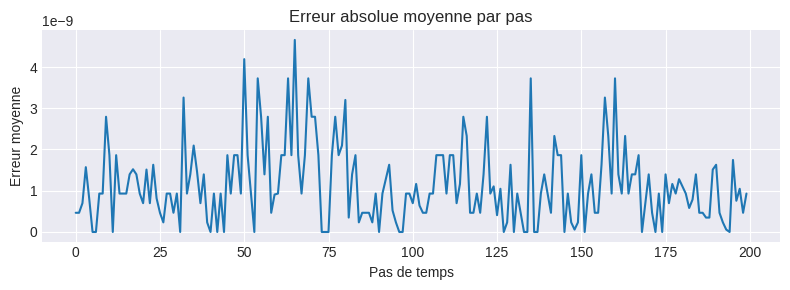

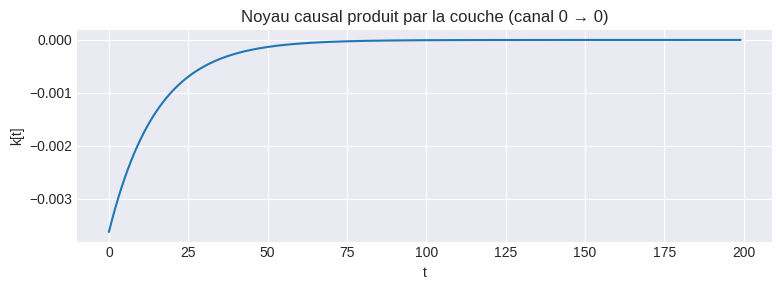

In [9]:
set_seed(123)
layer = DiagSSMLayer(d_in=1, d_out=1, N=32).to(DEVICE)
L_test = 200
u = torch.randn(8, L_test, 1, device=DEVICE)

y_conv, kernel = layer.forward_conv(u)
y_scan = layer.forward_scan(u)

diff = (y_conv - y_scan).abs().mean().item()
print(f"Écart moyen |conv - scan| : {diff:.3e}")

plt.figure(figsize=(8, 3))
plt.title("Erreur absolue moyenne par pas")
plt.plot((y_conv - y_scan)[0].abs().mean(dim=-1).detach().cpu().numpy())
plt.xlabel("Pas de temps")
plt.ylabel("Erreur moyenne")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.title("Noyau causal produit par la couche (canal 0 → 0)")
plt.plot(kernel[0, 0].detach().cpu().numpy())
plt.xlabel("t")
plt.ylabel("k[t]")
plt.tight_layout()
plt.show()


In [10]:
class SelectiveSSMLayer(nn.Module):
    """Version sélective : Δ_t et la porte de sortie dépendent de l'entrée."""

    def __init__(self, d_in: int, d_out: int, N: int = 64):
        super().__init__()
        self.N = N
        self.d_in = d_in
        self.d_out = d_out
        self.a_raw = nn.Parameter(torch.randn(N) * 0.01)
        self.B = nn.Parameter(torch.randn(N, d_in) * 0.1)
        self.C = nn.Parameter(torch.randn(d_out, N) * 0.1)
        self.D = nn.Parameter(torch.zeros(d_out, d_in))
        self.delta_net = nn.Linear(d_in, 1)
        self.out_gate = nn.Linear(d_in, d_out)

    def _a(self):
        return -_softplus_stable(self.a_raw)

    def forward(self, u):
        Bsz, L, _ = u.shape
        a = self._a()
        eps = 1e-6
        x = torch.zeros(Bsz, self.N, device=u.device, dtype=u.dtype)
        ys, deltas = [], []
        for t in range(L):
            u_t = u[:, t, :]
            dt_t = _softplus_stable(self.delta_net(u_t)) + 1e-5
            deltas.append(dt_t.squeeze(-1))
            eA = torch.exp(dt_t * a)
            coeff = torch.where(torch.abs(a) > eps, (eA - 1.0) / a, dt_t.expand_as(eA))
            Bu = u_t @ self.B.T
            x = eA * x + coeff * Bu
            y_t = x @ self.C.T
            g_t = torch.sigmoid(self.out_gate(u_t))
            y_t = g_t * y_t + (u_t @ self.D.T)
            ys.append(y_t)
        y = torch.stack(ys, dim=1)
        deltas = torch.stack(deltas, dim=1)
        return y, deltas


## 5. Entraînement sur les tâches synthétiques
Avant d'entraîner, clarifions les deux architectures que nous allons manipuler :

### 5.1 Couche SSM diagonale (filtrage)
La couche `DiagSSMLayer` implémente un SSM discret stationnaire avec dynamiques partagées sur toute la séquence :

$$\mathbf{x}_{t+1} = \bar{A} \mathbf{x}_t + \bar{B} \mathbf{u}_t, \qquad \mathbf{y}_t = C \mathbf{x}_t + D \mathbf{u}_t.$$

- Les paramètres $\bar{A} = \exp(\Delta t A)$ et $\bar{B}$ sont issus de la discrétisation diagonale vue plus haut, avec $A = \mathrm{diag}(a)$.
- Le terme $D$ agit comme un lien direct (*skip connection*) pour laisser passer une part de l'entrée.
- Cette couche peut s'évaluer soit par *scan* (récurrence) soit par *convolution* via le noyau causal $k_t = C \bar{A}^t \bar{B}$.

**Ce que nous allons observer :**
- La capacité du modèle à apprendre un filtre passe-bas causal pour la tâche de débruitage.
- L'impact du noyau appris sur la réponse fréquentielle : quelles bandes sont atténuées ou préservées ?
- La cohérence numérique entre les modes `scan` et `conv`.

### 5.2 Couche SSM sélective (adding task)
`SelectiveSSMLayer` reprend la structure précédente mais rend le pas de discrétisation et la projection de sortie dépendants de l'entrée courante :

$$
\Delta_t = \operatorname{softplus}(W_\Delta \mathbf{u}_t + b),
$$

$$
\mathbf{x}_{t+1} = \exp(\Delta_t A) \mathbf{x}_t + \left(\frac{\exp(\Delta_t A) - I}{A}\right) B \mathbf{u}_t,
$$

$$
\mathbf{g}_t = \sigma(W_g \mathbf{u}_t),
$$

$$
\mathbf{y}_t = \mathbf{g}_t \odot (C \mathbf{x}_t) + D \mathbf{u}_t.
$$

- Les poids $W_\Delta$ apprennent à moduler localement la mémoire : un \(\Delta_t\) large dilate la dynamique, un \(\Delta_t\) petit la resserre.
- La porte de sortie $\mathbf{g}_t$ sélectionne quelles composantes de l'état sont réinjectées.
- Cette flexibilité rapproche la couche de la philosophie Mamba et permet de traiter des séquences non stationnaires.

**Ce que nous allons apprendre :**
- Comment le modèle repère et pondère les instants pertinents de l'adding task.
- Comment les pas adaptatifs $\Delta_t$ se comportent autour des positions marquées par le masque.
- Comment une tête MLP simple peut transformer l'état final en prédiction scalaire.

Les classes `SSMFilterNet` et `SelectiveAdderNet` encapsulent ces couches respectivement pour le filtrage et l'adding task. Elles servent de squelettes pour les boucles d'entraînement et facilitent la collecte des sorties à analyser dans la section 7.


In [11]:
class SSMFilterNet(nn.Module):
    def __init__(self, d_in=1, d_out=1, N=64, mode="conv"):
        super().__init__()
        self.ssm = DiagSSMLayer(d_in, d_out, N=N, use_D=True)
        assert mode in ("conv", "scan")
        self.mode = mode

    def forward(self, u):
        if self.mode == "conv":
            y, k = self.ssm.forward_conv(u)
            return y, k
        y = self.ssm.forward_scan(u)
        return y, None


class SelectiveAdderNet(nn.Module):
    def __init__(self, d_in=2, N=64, hidden=64):
        super().__init__()
        self.ssm = SelectiveSSMLayer(d_in, d_out=32, N=N)
        self.head = nn.Sequential(
            nn.LayerNorm(32),
            nn.Linear(32, hidden),
            nn.GELU(),
            nn.Linear(hidden, 1),
        )

    def forward(self, u):
        y, deltas = self.ssm(u)
        y_last = y[:, -1, :]
        out = self.head(y_last)
        return out.squeeze(-1), deltas


In [12]:
@dataclass
class TrainConfig:
    task: str = "both"
    epochs_filter: int = 3
    epochs_add: int = 4
    batch_size: int = 64
    N: int = 64
    seq_len: int = 256
    n_train: int = 800
    n_val: int = 200
    lr: float = 3e-3
    mode_filter: str = "conv"
    device: str = DEVICE


### Fonctions d'entraînement
Nous suivons la MSE et la MAE, stockons les noyaux initiaux/final pour les visualisations et agrégeons les pertes par époque.


In [13]:
def train_filtering(cfg: TrainConfig):
    train_set = Filtering1DDataset(n_samples=cfg.n_train, seq_len=cfg.seq_len, seed=0)
    val_set = Filtering1DDataset(n_samples=cfg.n_val, seq_len=cfg.seq_len, seed=1)
    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False)

    net = SSMFilterNet(d_in=1, d_out=1, N=cfg.N, mode=cfg.mode_filter).to(cfg.device)
    opt = torch.optim.AdamW(net.parameters(), lr=cfg.lr)

    history = {"train": [], "val": []}
    best_val = float("inf")
    best_state = None

    for epoch in range(cfg.epochs_filter):
        net.train()
        total = 0.0
        t0 = time.time()
        for u, y in train_loader:
            u = u.to(cfg.device)
            y = y.to(cfg.device)
            opt.zero_grad()
            yhat, _ = net(u)
            loss = F.mse_loss(yhat, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            opt.step()
            total += loss.item() * u.size(0)
        train_loss = total / len(train_loader.dataset)

        net.eval()
        with torch.no_grad():
            val_loss = 0.0
            for u, y in val_loader:
                u = u.to(cfg.device)
                y = y.to(cfg.device)
                yhat, _ = net(u)
                val_loss += F.mse_loss(yhat, y).item() * u.size(0)
        val_loss /= len(val_loader.dataset)

        history["train"].append(train_loss)
        history["val"].append(val_loss)
        dt = time.time() - t0
        print(f"[Filtrage][Epoch {epoch+1}/{cfg.epochs_filter}] train={train_loss:.4f} val={val_loss:.4f} ({dt:.1f}s)")

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu() for k, v in net.state_dict().items()}

    if best_state is not None:
        net.load_state_dict({k: v.to(cfg.device) for k, v in best_state.items()})

    net.eval()
    with torch.no_grad():
        u_batch, y_batch = next(iter(val_loader))
        u_batch = u_batch.to(cfg.device)
        y_batch = y_batch.to(cfg.device)
        yhat_batch, kernel = net(u_batch)
        if kernel is not None:
            kernel_final = kernel.detach().cpu()
        else:
            kernel_final = None
        net.ssm.eval()
        y_conv, _ = net.ssm.forward_conv(u_batch[:8])
        y_scan = net.ssm.forward_scan(u_batch[:8])

    return net, history, (u_batch.cpu(), y_batch.cpu(), yhat_batch.cpu()), kernel_final, (y_conv.cpu(), y_scan.cpu())


def train_adding(cfg: TrainConfig):
    train_set = AddingTaskDataset(n_samples=cfg.n_train, seq_len=cfg.seq_len, seed=2)
    val_set = AddingTaskDataset(n_samples=cfg.n_val, seq_len=cfg.seq_len, seed=3)
    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False)

    net = SelectiveAdderNet(d_in=2, N=cfg.N).to(cfg.device)
    opt = torch.optim.AdamW(net.parameters(), lr=cfg.lr)

    history = {"train": [], "val": [], "mae": []}
    best_val = float("inf")
    best_state = None

    for epoch in range(cfg.epochs_add):
        net.train()
        total = 0.0
        for u, y in train_loader:
            u = u.to(cfg.device)
            y = y.to(cfg.device).squeeze(-1)
            opt.zero_grad()
            yhat, deltas = net(u)
            loss = F.mse_loss(yhat, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            opt.step()
            total += loss.item() * u.size(0)
        train_loss = total / len(train_loader.dataset)

        net.eval()
        with torch.no_grad():
            val_loss = 0.0
            mae = 0.0
            for u, y in val_loader:
                u = u.to(cfg.device)
                y = y.to(cfg.device).squeeze(-1)
                yhat, deltas = net(u)
                val_loss += F.mse_loss(yhat, y).item() * u.size(0)
                mae += (yhat - y).abs().mean().item() * u.size(0)
        val_loss /= len(val_loader.dataset)
        mae /= len(val_loader.dataset)

        history["train"].append(train_loss)
        history["val"].append(val_loss)
        history["mae"].append(mae)
        print(f"[Adding][Epoch {epoch+1}/{cfg.epochs_add}] train={train_loss:.4f} val={val_loss:.4f} MAE={mae:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu() for k, v in net.state_dict().items()}

    if best_state is not None:
        net.load_state_dict({k: v.to(cfg.device) for k, v in best_state.items()})

    net.eval()
    with torch.no_grad():
        u_batch, y_batch = next(iter(val_loader))
        u_batch = u_batch.to(cfg.device)
        y_batch = y_batch.to(cfg.device).squeeze(-1)
        yhat_batch, deltas_batch = net(u_batch)

    return net, history, (u_batch.cpu(), y_batch.cpu(), yhat_batch.cpu(), deltas_batch.cpu())


## 6. Lancement des expériences
Configurez le bloc suivant pour choisir la tâche à exécuter (`"filter"`, `"add"` ou `"both"`). Les réglages par défaut reproduisent l'expérience rapide (quelques minutes sur GPU T4).


In [14]:
cfg = TrainConfig()
cfg.task = "both"
cfg.mode_filter = "conv"
cfg.epochs_filter = 20
cfg.epochs_add = 20
cfg.batch_size = 128
cfg.N = 64
cfg.seq_len = 256
cfg.n_train = 800
cfg.n_val = 200
cfg.lr = 3e-3
cfg


TrainConfig(task='both', epochs_filter=20, epochs_add=20, batch_size=128, N=64, seq_len=256, n_train=800, n_val=200, lr=0.003, mode_filter='conv', device='cuda')

In [15]:
results = {}
if cfg.task in ("filter", "both"):
    print("=== Entraînement filtrage 1D ===")
    results["filter"] = train_filtering(cfg)

if cfg.task in ("add", "both"):
    print("=== Entraînement adding task ===")
    results["add"] = train_adding(cfg)


=== Entraînement filtrage 1D ===
[Filtrage][Epoch 1/20] train=0.6870 val=0.4851 (0.5s)
[Filtrage][Epoch 2/20] train=0.3782 val=0.2434 (0.2s)
[Filtrage][Epoch 3/20] train=0.1990 val=0.1709 (0.2s)
[Filtrage][Epoch 4/20] train=0.1827 val=0.1871 (0.2s)
[Filtrage][Epoch 5/20] train=0.1760 val=0.1563 (0.2s)
[Filtrage][Epoch 6/20] train=0.1526 val=0.1480 (0.2s)
[Filtrage][Epoch 7/20] train=0.1485 val=0.1433 (0.2s)
[Filtrage][Epoch 8/20] train=0.1409 val=0.1340 (0.2s)
[Filtrage][Epoch 9/20] train=0.1333 val=0.1298 (0.2s)
[Filtrage][Epoch 10/20] train=0.1289 val=0.1252 (0.2s)
[Filtrage][Epoch 11/20] train=0.1241 val=0.1210 (0.3s)
[Filtrage][Epoch 12/20] train=0.1198 val=0.1179 (0.4s)
[Filtrage][Epoch 13/20] train=0.1161 val=0.1150 (0.4s)
[Filtrage][Epoch 14/20] train=0.1137 val=0.1126 (0.4s)
[Filtrage][Epoch 15/20] train=0.1119 val=0.1104 (0.3s)
[Filtrage][Epoch 16/20] train=0.1095 val=0.1086 (0.4s)
[Filtrage][Epoch 17/20] train=0.1076 val=0.1070 (0.3s)
[Filtrage][Epoch 18/20] train=0.1057 val=

## 7. Visualisations et analyses
Nous proposons plusieurs visualisations clé pour interpréter les modèles entraînés.


### 7.1 Filtrage : comparaison entrée / sortie / cible
Cette cellule trace la sortie du modèle sur un batch de validation, ainsi que le noyau appris (domaine temporel et fréquentiel) et l'écart conv vs scan.


> **Lecture guidée**  
> - Comparez la sortie du modèle à la cible : la courbe prédite doit lisser l'entrée tout en conservant la structure basse fréquence.  
> - Inspectez le noyau causal : sa forme temporelle doit refléter un filtre régularisant (coefficients qui décroissent).  
> - Analysez la réponse fréquentielle : la magnitude en dB doit montrer une atténuation nette des hautes fréquences (comportement passe-bas).  
> - Vérifiez l'écart `conv` vs `scan` : une différence faible confirme la cohérence entre les deux implémentations (point de vigilance numérique).



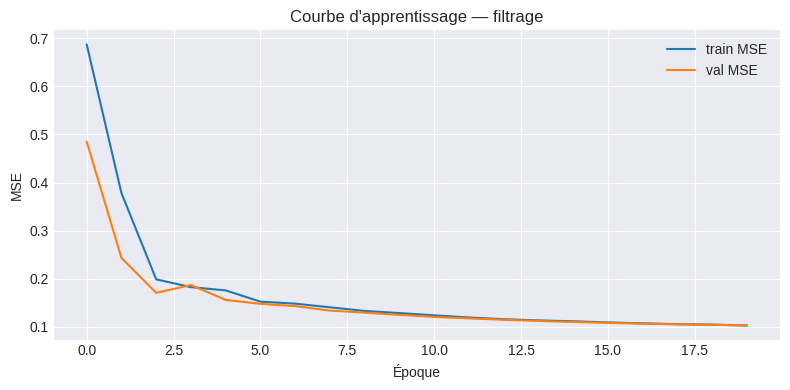

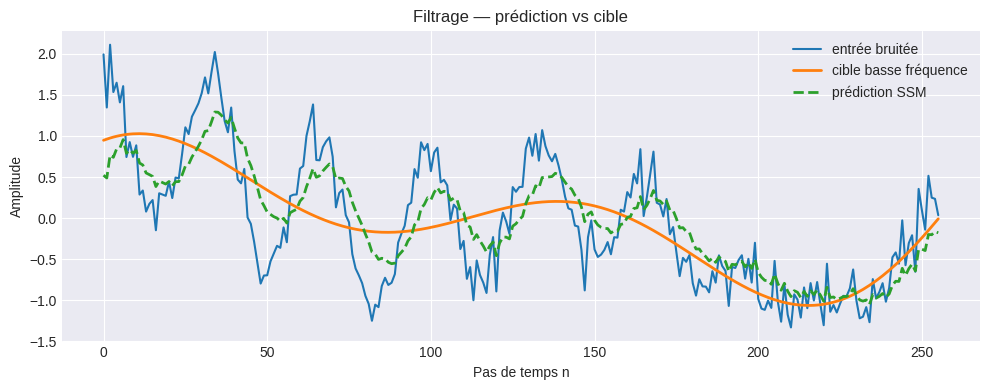

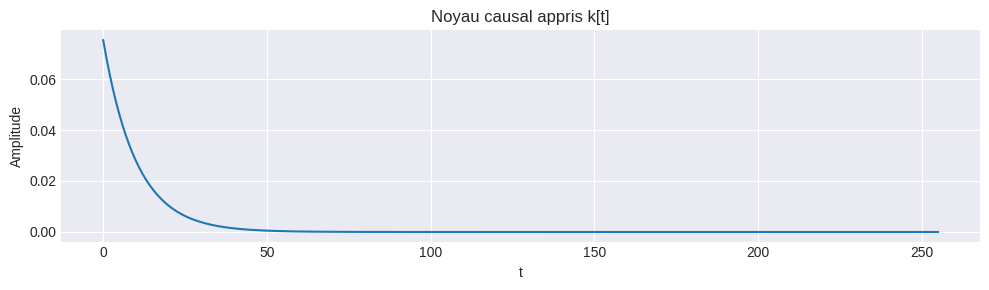

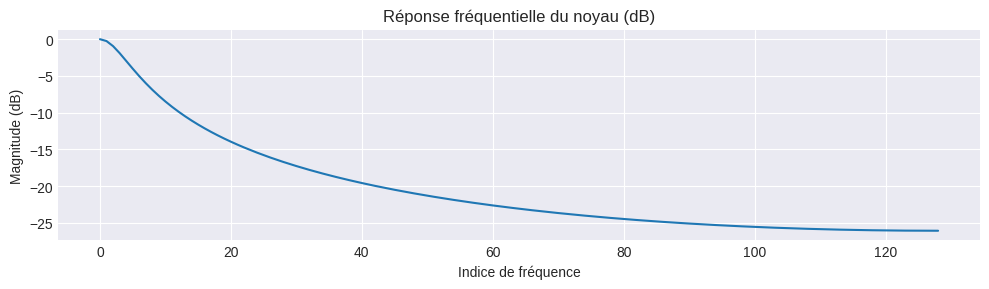

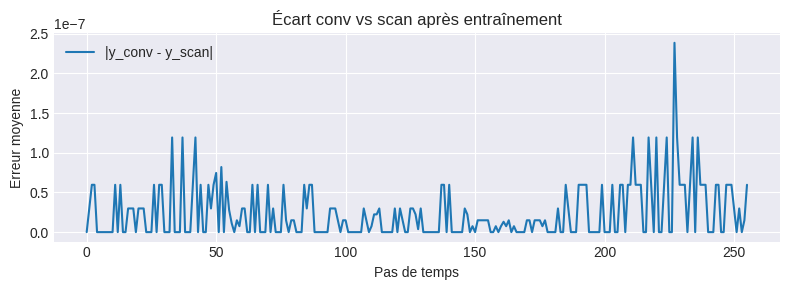

In [16]:
if "filter" in results:
    net, history, (u_batch, y_batch, yhat_batch), kernel_final, (y_conv, y_scan) = results["filter"]

    plt.figure(figsize=(8, 4))
    plt.title("Courbe d'apprentissage — filtrage")
    plt.plot(history["train"], label="train MSE")
    plt.plot(history["val"], label="val MSE")
    plt.xlabel("Époque")
    plt.ylabel("MSE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    idx = 0
    u0 = u_batch[idx, :, 0].numpy()
    y0 = y_batch[idx, :, 0].numpy()
    yhat0 = yhat_batch[idx, :, 0].numpy()

    plt.figure(figsize=(10, 4))
    plt.title("Filtrage — prédiction vs cible")
    plt.plot(u0, label="entrée bruitée")
    plt.plot(y0, label="cible basse fréquence", linewidth=2)
    plt.plot(yhat0, label="prédiction SSM", linewidth=2, linestyle="--")
    plt.xlabel("Pas de temps n")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if kernel_final is not None:
        k_final = kernel_final[0, 0].numpy()
        plt.figure(figsize=(10, 3))
        plt.title("Noyau causal appris k[t]")
        plt.plot(k_final)
        plt.xlabel("t")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()

        fft_vals = np.fft.rfft(k_final)
        mag = np.abs(fft_vals)
        mag_db = 20 * np.log10(mag / (mag.max() + 1e-12))
        plt.figure(figsize=(10, 3))
        plt.title("Réponse fréquentielle du noyau (dB)")
        plt.plot(mag_db)
        plt.xlabel("Indice de fréquence")
        plt.ylabel("Magnitude (dB)")
        plt.tight_layout()
        plt.show()

    diff = (y_conv - y_scan).abs().mean(dim=-1).numpy()
    plt.figure(figsize=(8, 3))
    plt.title("Écart conv vs scan après entraînement")
    plt.plot(diff[0], label="|y_conv - y_scan|")
    plt.xlabel("Pas de temps")
    plt.ylabel("Erreur moyenne")
    plt.legend()
    plt.tight_layout()
    plt.show()


### 7.2 Adding task : dynamique sélective
Nous observons la convergence des pertes, le comportement des pas adaptatifs $\Delta_t$ et la précision finale.


> **Lecture guidée**  
> - Sur la figure des entrées, vérifiez que la prédiction finale suit la somme des deux valeurs marquées.  
> - Observez la courbe des $\Delta_t$ : l'augmentation locale autour des positions marquées illustre l'adaptation temporelle recherchée.  
> - Suivez les courbes d'apprentissage : une décroissance conjointe des MSE/MAE confirme la stabilisation du modèle.  
> - Interprétez ces graphiques comme l'équivalent d'un *time-varying filter* qui s'ajuste selon l'importance de l'entrée. 



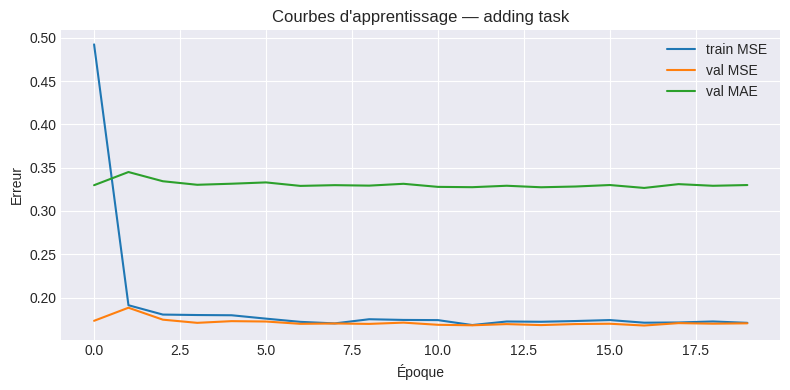

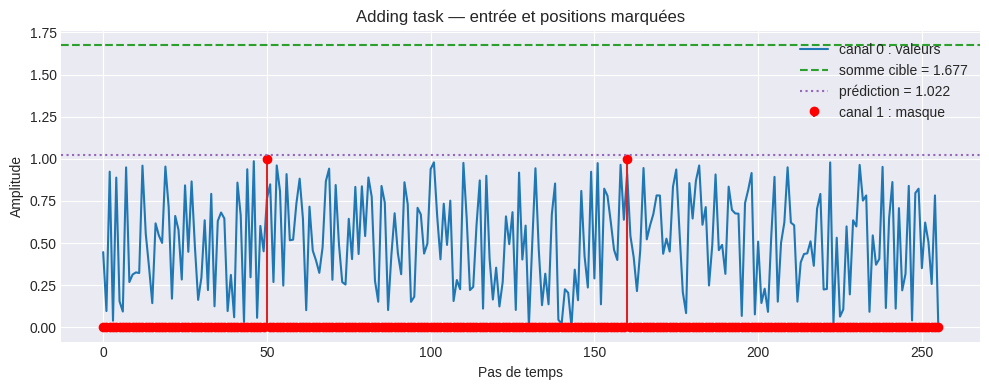

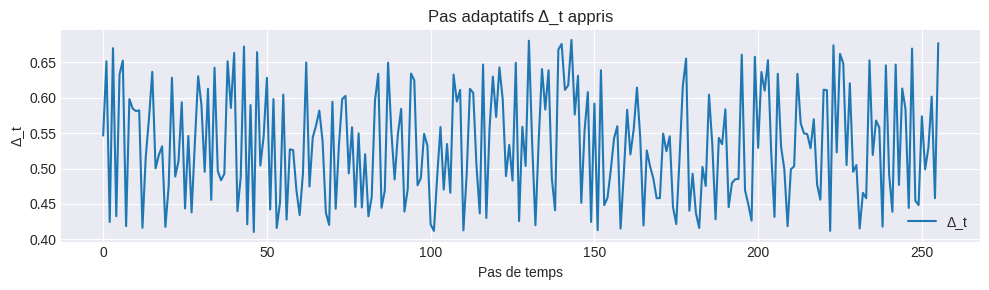

In [20]:
if "add" in results:
    net, history, (u_batch, y_batch, yhat_batch, deltas_batch) = results["add"]

    plt.figure(figsize=(8, 4))
    plt.title("Courbes d'apprentissage — adding task")
    plt.plot(history["train"], label="train MSE")
    plt.plot(history["val"], label="val MSE")
    plt.plot(history["mae"], label="val MAE")
    plt.xlabel("Époque")
    plt.ylabel("Erreur")
    plt.legend()
    plt.tight_layout()
    plt.show()

    idx = 1
    u0 = u_batch[idx].numpy()
    y0 = y_batch[idx].item()
    yhat0 = yhat_batch[idx].item()
    deltas0 = deltas_batch[idx].numpy()

    plt.figure(figsize=(10, 4))
    plt.title("Adding task — entrée et positions marquées")
    plt.plot(u0[:, 0], label="canal 0 : valeurs")
    plt.stem(np.arange(len(u0)), u0[:, 1], linefmt="tab:red", markerfmt="ro", basefmt=" ", label="canal 1 : masque")
    plt.axhline(y0, color="tab:green", linestyle="--", label=f"somme cible = {y0:.3f}")
    plt.axhline(yhat0, color="tab:purple", linestyle=":", label=f"prédiction = {yhat0:.3f}")
    plt.xlabel("Pas de temps")
    plt.ylabel("Amplitude")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 3))
    plt.title("Pas adaptatifs Δ_t appris")
    plt.plot(deltas0, label="Δ_t")
    plt.xlabel("Pas de temps")
    plt.ylabel("Δ_t")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 8. Pistes d'exploration
Pour aller plus loin :
- Augmenter la dimension cachée $N$ et observer l'impact sur les réponses fréquentielles.
- Passer en mode `scan` pour mesurer le coût séquentiel versus la version convolutionnelle.
- Visualiser plusieurs noyaux initiaux/finals pour comprendre la diversité des filtres appris.
- Implémenter un batching aléatoire de $\Delta_t$ (vectorisation par état) pour se rapprocher davantage de Mamba.

Bon TP !
